In [1]:
import os
import wget
import array
import gzip
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import torch
from torch import nn
from collections import defaultdict
from scipy.spatial import distance
from sklearn.manifold import TSNE


Data is available at http://cseweb.ucsd.edu/~jmcauley/pml/data/. 
- Download and save to your own directory.
- Or, run following script to save it into `Chapter_9/data` folder automatically.

In [2]:
filenames = [
    'image_features_Baby.b',
    'meta_Baby.json.gz',
    'meta_Musical_Instruments.json.gz',
    'image_features_Musical_Instruments.b',
    'meta_Musical_Instruments.json.gz',
]

dataDir = './data'
url = 'http://jmcauley.ucsd.edu/pml_data'

if not os.path.exists(dataDir):
    os.makedirs(dataDir)
for filename in filenames:
    wget.download(os.path.join(url, filename), out=dataDir)

print("Done!")


Done!


# Visual compatibility model in `TensorFlow` and `PyTorch`

This code reads image data in a specific binary format, described here: http://jmcauley.ucsd.edu/data/amazon/links.html

In [3]:
def readImageFeatures(path):
    f = open(path, 'rb')
    while True:
        asin = f.read(10).decode('utf-8')
        if len(asin) < 10:
            break
        a = array.array('f')
        a.fromfile(f, 4096)
        yield str(asin), a.tolist()


In [4]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)


## `TensorFlow` Implementation

In [5]:
X = []
asinPos = {}

for asin, f in readImageFeatures(os.path.join(dataDir, 'image_features_Baby.b')):
    asinPos[asin] = len(X)
    X.append(tf.constant(f, shape=[1, len(f)]))


2022-03-24 15:29:18.013495: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-24 15:29:18.013537: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Zhankui
2022-03-24 15:29:18.013545: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Zhankui
2022-03-24 15:29:18.013666: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-03-24 15:29:18.013689: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-03-24 15:29:18.013696: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-03-24 15:29:18.014058: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in

Extract metadata describing ground-truth compatibility relationships among items

In [6]:
compat = []
asinList = list(asinPos.keys())
for l in parse(os.path.join(dataDir, 'meta_Baby.json.gz')):
    a1 = l['asin']
    if 'related' in l and 'also_bought' in l['related']:
        for a2 in l['related']['also_bought']:
            if a1 in asinPos and a2 in asinPos:
                compat.append((asinPos[a1], asinPos[a2], 1))
                compat.append((random.randint(0, len(X)-1),
                              random.randint(0, len(X)-1), 0))


Number of compatible pairs

In [7]:
len(compat)


1698622

In [8]:
featDim = X[0].shape[1]  # Image feature dimensionality
styleDim = 5  # Dimensionality of compressed (projected) representations


In [9]:
featDim


4096

Define the compatibility model

In [10]:
optimizer = tf.keras.optimizers.Adam(0.00001)


In [11]:
class CompatibilityModel(tf.keras.Model):
    def __init__(self, featDim, styleDim):
        super(CompatibilityModel, self).__init__()
        self.E1 = tf.Variable(tf.random.normal(
            [featDim, styleDim], stddev=0.001))
        self.E2 = tf.Variable(tf.random.normal(
            [featDim, styleDim], stddev=0.001))
        self.c = tf.Variable(0.0)

    def predict(self, x1, x2):
        s1 = tf.matmul(x1, self.E1)
        s2 = tf.matmul(x2, self.E2)
        return tf.math.sigmoid(self.c - tf.reduce_sum(tf.math.squared_difference(s1, s2)))

    def call(self, x1, x2, y):
        return -tf.math.log(self.predict(x1, x2)*(2*y - 1) - y + 1)


model = CompatibilityModel(featDim, styleDim)


In [12]:
def trainingStep(compat):
    with tf.GradientTape() as tape:
        (i1, i2, y) = random.choice(compat)
        x1, x2 = X[i1], X[i2]
        objective = model(x1, x2, y)
    gradients = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return objective.numpy()


In [13]:
for i in range(50000):
    obj = trainingStep(compat)
    if (i % 5000 == 4999):
        print("iteration " + str(i+1) + ", objective = " + str(obj))


iteration 5000, objective = 0.7239198
iteration 10000, objective = 0.57909244
iteration 15000, objective = 0.75466865
iteration 20000, objective = 0.2868323
iteration 25000, objective = 1.1394196
iteration 30000, objective = 0.461419
iteration 35000, objective = 0.7189325
iteration 40000, objective = 0.52887386
iteration 45000, objective = 0.13579811
iteration 50000, objective = 0.79994273


# Exercises

### 9.1

For these exercises we use musical instrument data; we do so because (a) it has fine-grained subcategories (e.g. "accessories", "guitars", etc.) which can be used for these exercises; and (b) because it is small. These exercises might ideally be run with a large category of (e.g.) clothing images, though such datasets are larger and more difficult to work with.

First collect the subcategories associated with each item (for use in Exercise 9.3)

In [14]:
categories = dict()
itemsPerCategory = defaultdict(set)
for l in parse(os.path.join(dataDir, 'meta_Musical_Instruments.json.gz')):
    cats = l['categories'][0]
    if len(cats) < 2:
        continue
    # Extract the "second level" (or sub-) category, for products that have them (ignore others)
    cat = cats[1]
    categories[l['asin']] = cat
    itemsPerCategory[cat].add(l['asin'])


Read image data

In [15]:
X = []
asinPos = {}
posPerCategory = defaultdict(set)

for asin, f in readImageFeatures(os.path.join(dataDir, 'image_features_Musical_Instruments.b')):
    if not asin in categories:  # Skip items for which we don't have a category
        continue
    asinPos[asin] = len(X)
    posPerCategory[categories[asin]].add(asinPos[asin])
    X.append(tf.constant(f, shape=[1, len(f)]))


Extract compatibility relationships. Build our collection of "difficult" negatives consisting of items from the same category.

In [16]:
compat = []
asinList = list(asinPos.keys())
for l in parse(os.path.join(dataDir, 'meta_Musical_Instruments.json.gz')):
    a1 = l['asin']
    if not a1 in categories:
        continue
    cat = categories[a1]
    if 'related' in l and 'also_bought' in l['related']:
        for a2 in l['related']['also_bought']:
            if not a2 in categories or categories[a2] != cat:
                continue  # Only consider positive relations of the same category
            if a1 in asinPos and a2 in asinPos:
                compat.append((asinPos[a1], asinPos[a2], 1))
                negSameCat = random.sample(posPerCategory[cat], 1)[0]
                compat.append((asinPos[a1], negSameCat, 0))


In [17]:
len(compat)


809528

In [18]:
featDim = X[0].shape[1]  # Image feature dimensionality
styleDim = 5  # Dimensionality of compressed (projected) representations


In [19]:
optimizer = tf.keras.optimizers.Adam(0.00001)


In [20]:
class CompatibilityModel(tf.keras.Model):
    def __init__(self, featDim, styleDim):
        super(CompatibilityModel, self).__init__()
        self.E1 = tf.Variable(tf.random.normal(
            [featDim, styleDim], stddev=0.001))
        self.E2 = tf.Variable(tf.random.normal(
            [featDim, styleDim], stddev=0.001))
        self.c = tf.Variable(0.0)

    def predict(self, x1, x2):
        s1 = tf.matmul(x1, self.E1)
        s2 = tf.matmul(x2, self.E2)
        return tf.math.sigmoid(self.c - tf.reduce_sum(tf.math.squared_difference(s1, s2)))

    def call(self, x1, x2, y):
        return -tf.math.log(self.predict(x1, x2)*(2*y - 1) - y + 1)


### 9.2 / 9.3

Modify the model to compute similarity based on the inner product rather than Euclidean distance

In [21]:
class CompatibilityModelInner(tf.keras.Model):
    def __init__(self, featDim, styleDim):
        super(CompatibilityModel, self).__init__()
        self.E1 = tf.Variable(tf.random.normal(
            [featDim, styleDim], stddev=0.001))
        self.E2 = tf.Variable(tf.random.normal(
            [featDim, styleDim], stddev=0.001))
        self.c = tf.Variable(0.0)

    def predict(self, x1, x2):
        s1 = tf.matmul(x1, self.E1)
        s2 = tf.matmul(x2, self.E2)
        return tf.math.sigmoid(self.c + tf.tensordot(s1, s2, 1))

    def call(self, x1, x2, y):
        return -tf.math.log(self.predict(x1, x2)*(2*y - 1) - y + 1)


Compare models based on the inner product and Euclidean distance. Both make use of "difficult" negatives (Exercise 9.3)

In [22]:
model1 = CompatibilityModel(featDim, styleDim)
model2 = CompatibilityModel(featDim, styleDim)


In [23]:
def trainingStep(model, compat):
    with tf.GradientTape() as tape:
        (i1, i2, y) = random.choice(compat)
        x1, x2 = X[i1], X[i2]
        objective = model(x1, x2, y)
    gradients = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return objective.numpy()


In [24]:
random.shuffle(compat)


In [25]:
compatTrain = compat[:700000]
compatTest = compat[700000:]


In [26]:
for i in range(50000):
    obj = trainingStep(model1, compatTrain)
    if (i % 5000 == 4999):
        print("iteration " + str(i+1) + ", objective = " + str(obj))


iteration 5000, objective = 0.7674893
iteration 10000, objective = 0.78953576
iteration 15000, objective = 0.58010614
iteration 20000, objective = 0.71493345
iteration 25000, objective = 0.795738
iteration 30000, objective = 0.87193996
iteration 35000, objective = 0.48919448
iteration 40000, objective = 0.17854594
iteration 45000, objective = 0.54287994
iteration 50000, objective = 0.981735


In [27]:
for i in range(50000):
    obj = trainingStep(model2, compatTrain)
    if (i % 5000 == 4999):
        print("iteration " + str(i+1) + ", objective = " + str(obj))


iteration 5000, objective = 0.8080462
iteration 10000, objective = 0.58923113
iteration 15000, objective = 0.8187968
iteration 20000, objective = 0.31714982
iteration 25000, objective = 0.117897294
iteration 30000, objective = 0.13508478
iteration 35000, objective = 0.73516166
iteration 40000, objective = 0.840213
iteration 45000, objective = 0.31883702
iteration 50000, objective = 0.80575603


Compute accuracy (what fraction of positive relationships were predicted as positive)

In [28]:
acc = 0

for (i1, i2, y) in compatTest:
    x1, x2 = X[i1], X[i2]
    p = model1(x1, x2, y)
    if (p.numpy() > 0.5) == (y == 1):
        acc += 1

acc / len(compatTest)


0.8190782265722008

In [29]:
acc = 0

for (i1, i2, y) in compatTest:
    x1, x2 = X[i1], X[i2]
    p = model2(x1, x2, y)
    if (p.numpy() > 0.5) == (y == 1):
        acc += 1

acc / len(compatTest)


0.7875246512307356

### 9.4

t-SNE embedding

In [30]:
Xembed = []

for asin in asinList:
    i = asinPos[asin]
    x = X[i]
    embedded = list(tf.matmul(x, model1.E1).numpy()[0])
    Xembed.append(embedded)


In [31]:
Xembed2 = TSNE(n_components=2).fit_transform(Xembed)


/home/zhankui/anaconda3/envs/pml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhankui/anaconda3/envs/pml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [32]:
scatterPlotsX = defaultdict(list)
scatterPlotsY = defaultdict(list)
for xy, asin in zip(Xembed2, asinList):
    if asin in categories:
        cat = categories[asin]
        try:
            scatterPlotsX[cat].append(xy[0])
            scatterPlotsY[cat].append(xy[1])
        except Exception as e:
            pass


Scatterplots by subcategory aren't particularly interesting in this case. Try e.g. price or brand for more compelling examples.

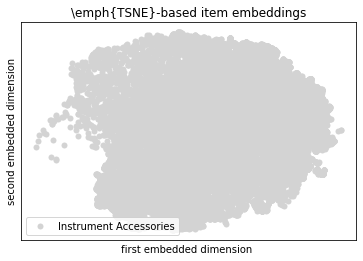

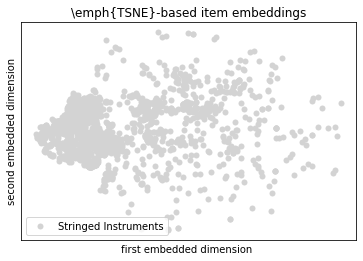

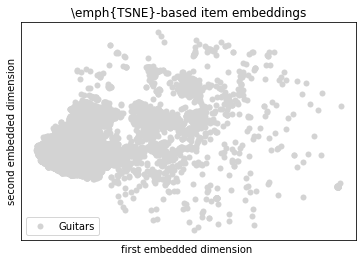

In [33]:
for cat in ['Instrument Accessories', 'Stringed Instruments', 'Guitars']:
    plt.scatter(scatterPlotsX[cat],
                scatterPlotsY[cat], color='lightgrey', lw=0, label=cat)
    plt.legend(loc='lower left')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("first embedded dimension ")
    plt.ylabel("second embedded dimension")
    plt.title("\emph{TSNE}-based item embeddings")
    plt.show()


## `PyTorch` Implementation

In [34]:
X = []
asinPos = {}

for asin, f in readImageFeatures(os.path.join(dataDir, 'image_features_Baby.b')):
    asinPos[asin] = len(X)
    X.append(torch.Tensor([f]))


Extract metadata describing ground-truth compatibility relationships among items

In [35]:
compat = []
asinList = list(asinPos.keys())
for l in parse(os.path.join(dataDir, 'meta_Baby.json.gz')):
    a1 = l['asin']
    if 'related' in l and 'also_bought' in l['related']:
        for a2 in l['related']['also_bought']:
            if a1 in asinPos and a2 in asinPos:
                compat.append((asinPos[a1], asinPos[a2], 1))
                compat.append((random.randint(0, len(X)-1),
                              random.randint(0, len(X)-1), 0))


Number of compatible pairs

In [36]:
len(compat)


1698622

Image and representation dimensionality

In [37]:
featDim = X[0].shape[1]  # Image feature dimensionality
styleDim = 5  # Dimensionality of compressed (projected) representations

featDim, styleDim


(4096, 5)

Define the compatibility model

In [38]:
class CompatibilityModel(nn.Module):
    def __init__(self, featDim, styleDim):
        super(CompatibilityModel, self).__init__()
        self.E1 = nn.Linear(featDim, styleDim, bias=False)
        nn.init.normal_(self.E1.weight, std=0.001)
        self.E2 = nn.Linear(featDim, styleDim, bias=False)
        nn.init.normal_(self.E2.weight, std=0.001)
        self.c = nn.Parameter(torch.Tensor([0.0]))

    def forward(self, x1, x2):
        s1 = self.E1(x1)
        s2 = self.E2(x2)
        p = (self.c - ((s1-s2)**2).sum(dim=-1)).sigmoid()
        return p

    def loss(self, x1, x2, y):
        return -(self.forward(x1, x2)*(2*y - 1) - y + 1).log().mean()


model = CompatibilityModel(featDim, styleDim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)


In [39]:
def trainingStep(model, compat, optimizer):
    # gradient reset
    optimizer.zero_grad()
    # data generation
    (i1, i2, y) = random.choice(compat)
    x1, x2 = X[i1], X[i2]
    y = torch.Tensor([y])
    # loss calculation
    loss = model.loss(x1, x2, y)
    # gradient calculation
    loss.backward()
    # weight update
    optimizer.step()
    return loss.item()


In [40]:
for i in range(50000):
    loss = trainingStep(model, compat, optimizer)
    if (i % 5000 == 4999):
        print("iteration " + str(i+1) + ", loss = " + str(loss))


iteration 5000, loss = 0.6941077709197998
iteration 10000, loss = 0.5178741812705994
iteration 15000, loss = 0.7304853796958923
iteration 20000, loss = 0.6167329549789429
iteration 25000, loss = 0.5481924414634705
iteration 30000, loss = 0.7128235101699829
iteration 35000, loss = 0.9252533912658691
iteration 40000, loss = 0.8074054718017578
iteration 45000, loss = 1.0964837074279785
iteration 50000, loss = 0.49173736572265625


# Exercises

### 9.1

For these exercises we use musical instrument data; we do so because (a) it has fine-grained subcategories (e.g. "accessories", "guitars", etc.) which can be used for these exercises; and (b) because it is small. These exercises might ideally be run with a large category of (e.g.) clothing images, though such datasets are larger and more difficult to work with.

First collect the subcategories associated with each item (for use in Exercise 9.3)

In [41]:
categories = dict()
itemsPerCategory = defaultdict(set)
for l in parse(os.path.join(dataDir, 'meta_Musical_Instruments.json.gz')):
    cats = l['categories'][0]
    if len(cats) < 2:
        continue
    # Extract the "second level" (or sub-) category, for products that have them (ignore others)
    cat = cats[1]
    categories[l['asin']] = cat
    itemsPerCategory[cat].add(l['asin'])


Read image data

In [42]:
X = []
asinPos = {}
posPerCategory = defaultdict(set)

for asin, f in readImageFeatures(os.path.join(dataDir, 'image_features_Musical_Instruments.b')):
    if not asin in categories:  # Skip items for which we don't have a category
        continue
    asinPos[asin] = len(X)
    posPerCategory[categories[asin]].add(asinPos[asin])
    X.append(torch.Tensor([f]))


Extract compatibility relationships. Build our collection of "difficult" negatives consisting of items from the same category.

In [43]:
compat = []
asinList = list(asinPos.keys())
for l in parse(os.path.join(dataDir, 'meta_Musical_Instruments.json.gz')):
    a1 = l['asin']
    if not a1 in categories:
        continue
    cat = categories[a1]
    if 'related' in l and 'also_bought' in l['related']:
        for a2 in l['related']['also_bought']:
            if not a2 in categories or categories[a2] != cat:
                continue  # Only consider positive relations of the same category
            if a1 in asinPos and a2 in asinPos:
                compat.append((asinPos[a1], asinPos[a2], 1))
                negSameCat = random.sample(posPerCategory[cat], 1)[0]
                compat.append((asinPos[a1], negSameCat, 0))

len(compat)


809528

In [44]:
featDim = X[0].shape[1]  # Image feature dimensionality
styleDim = 5  # Dimensionality of compressed (projected) representations


### 9.2 / 9.3

Modify the model to compute similarity based on the inner product rather than Euclidean distance

In [45]:
class CompatibilityModelInner(nn.Module):
    def __init__(self, featDim, styleDim):
        super(CompatibilityModelInner, self).__init__()
        self.E1 = nn.Linear(featDim, styleDim, bias=False)
        nn.init.normal_(self.E1.weight, std=0.001)
        self.E2 = nn.Linear(featDim, styleDim, bias=False)
        nn.init.normal_(self.E2.weight, std=0.001)
        self.c = nn.Parameter(torch.Tensor([0.0]))

    def forward(self, x1, x2):
        s1 = self.E1(x1)
        s2 = self.E2(x2)
        p = (self.c + (s1*s2).sum(dim=-1)).sigmoid()
        return p

    def loss(self, x1, x2, y):
        return -(self.forward(x1, x2)*(2*y - 1) - y + 1).log().mean()


In [46]:
model1 = CompatibilityModel(featDim, styleDim)
optimizer1 = torch.optim.Adam(model.parameters(), lr=0.00001)

model2 = CompatibilityModelInner(featDim, styleDim)
optimizer2 = torch.optim.Adam(model.parameters(), lr=0.00001)


In [47]:
random.shuffle(compat)

compatTrain = compat[:700000]
compatTest = compat[700000:]


In [48]:
for i in range(50000):
    loss = trainingStep(model1, compatTrain, optimizer1)
    if (i % 5000 == 4999):
        print("iteration " + str(i+1) + ", loss = " + str(loss))


iteration 5000, loss = 0.8099606037139893
iteration 10000, loss = 0.7251449823379517
iteration 15000, loss = 0.7361866235733032
iteration 20000, loss = 0.6583056449890137
iteration 25000, loss = 0.6860982179641724
iteration 30000, loss = 0.7321298122406006
iteration 35000, loss = 0.7298062443733215
iteration 40000, loss = 0.7608926296234131
iteration 45000, loss = 0.7123979926109314
iteration 50000, loss = 0.720145583152771


In [49]:
for i in range(50000):
    loss = trainingStep(model2, compatTrain, optimizer2)
    if (i % 5000 == 4999):
        print("iteration " + str(i+1) + ", loss = " + str(loss))


iteration 5000, loss = 0.696386456489563
iteration 10000, loss = 0.6946598887443542
iteration 15000, loss = 0.6978219151496887
iteration 20000, loss = 0.6959386467933655
iteration 25000, loss = 0.6885499954223633
iteration 30000, loss = 0.6953397989273071
iteration 35000, loss = 0.6996220946311951
iteration 40000, loss = 0.6909065246582031
iteration 45000, loss = 0.6967208981513977
iteration 50000, loss = 0.6856837272644043


Compute accuracy (what fraction of positive relationships were predicted as positive)

In [50]:
acc = 0

for (i1, i2, y) in compatTest:
    x1, x2 = X[i1], X[i2]
    p = model1(x1, x2)
    if (p.item() > 0.5) == (y == 1):
        acc += 1

acc / len(compatTest)


0.4997900080344752

In [51]:
acc = 0

for (i1, i2, y) in compatTest:
    x1, x2 = X[i1], X[i2]
    p = model2(x1, x2)
    if (p.item() > 0.5) == (y == 1):
        acc += 1

acc / len(compatTest)


0.4939284931706961

### 9.4

t-SNE embedding

In [52]:
Xembed = []

for asin in asinList:
    i = asinPos[asin]
    x = X[i]
    embedded = list(model1.E1(x).detach().numpy()[0])
    Xembed.append(embedded)

Xembed2 = TSNE(n_components=2).fit_transform(Xembed)


/home/zhankui/anaconda3/envs/pml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhankui/anaconda3/envs/pml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


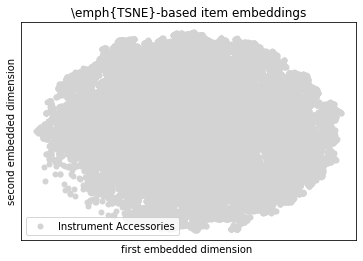

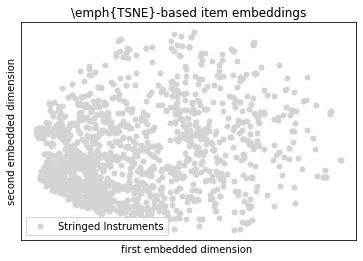

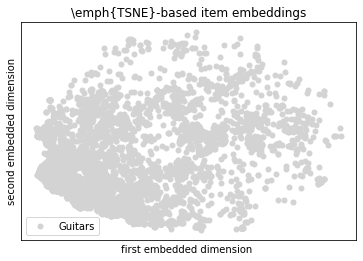

In [53]:
scatterPlotsX = defaultdict(list)
scatterPlotsY = defaultdict(list)
for xy, asin in zip(Xembed2, asinList):
    if asin in categories:
        cat = categories[asin]
        try:
            scatterPlotsX[cat].append(xy[0])
            scatterPlotsY[cat].append(xy[1])
        except Exception as e:
            pass

for cat in ['Instrument Accessories', 'Stringed Instruments', 'Guitars']:
    plt.scatter(scatterPlotsX[cat],
                scatterPlotsY[cat], color='lightgrey', lw=0, label=cat)
    plt.legend(loc='lower left')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("first embedded dimension ")
    plt.ylabel("second embedded dimension")
    plt.title("\emph{TSNE}-based item embeddings")
    plt.show()
